<a href="https://colab.research.google.com/github/ReemAbdelhaleemHassan/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Reading from Google Drive**

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Upload the dataset**

In [ ]:
link = 'https://drive.google.com/file/d/1LHwz3Nl6cFkdQOpDlwu-pYklLzerGP79/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Crema.zip')

## **Unzipping**

In [ ]:
! unzip Crema.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1031_DFA_DIS_XX.wav  
  inflating: Crema/1031_DFA_FEA_XX.wav  
  inflating: Crema/1031_DFA_HAP_XX.wav  
  inflating: Crema/1031_DFA_NEU_XX.wav  
  inflating: Crema/1031_DFA_SAD_XX.wav  
  inflating: Crema/1031_IEO_ANG_HI.wav  
  inflating: Crema/1031_IEO_ANG_LO.wav  
  inflating: Crema/1031_IEO_ANG_MD.wav  
  inflating: Crema/1031_IEO_DIS_HI.wav  
  inflating: Crema/1031_IEO_DIS_LO.wav  
  inflating: Crema/1031_IEO_DIS_MD.wav  
  inflating: Crema/1031_IEO_FEA_HI.wav  
  inflating: Crema/1031_IEO_FEA_LO.wav  
  inflating: Crema/1031_IEO_FEA_MD.wav  
  inflating: Crema/1031_IEO_HAP_HI.wav  
  inflating: Crema/1031_IEO_HAP_LO.wav  
  inflating: Crema/1031_IEO_HAP_MD.wav  
  inflating: Crema/1031_IEO_NEU_XX.wav  
  inflating: Crema/1031_IEO_SAD_HI.wav  
  inflating: Crema/1031_IEO_SAD_LO.wav  
  inflating: Crema/1031_IEO_SAD_MD.wav  
  inflating: Crema/1031_IOM_ANG_XX.wav  
  inflating: Crema/1031_IOM_DIS_XX.wav  
  infl

## **Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wave, sys
import librosa
import librosa.display
from IPython.display import Audio
from IPython.display import display
import os
import soundfile as sf
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset



##**Creating dataframe**

In [ ]:
def read_data(root):
  data = []

  directory = os.fsencode(root)
  for file in os.listdir(directory):
      filename = os.fsdecode(file)
      filename= root + filename
      data.append([filename,filename[24:27]])
  return pd.DataFrame(data, columns = ['File_path', 'Class'])

In [ ]:
data_df = read_data("/content/Crema/")

In [ ]:
data_df.head()

,File_path,Class
0,/content/Crema/1082_IWL_FEA_XX.wav,FEA
1,/content/Crema/1062_TSI_HAP_XX.wav,HAP
2,/content/Crema/1013_IEO_FEA_MD.wav,FEA
3,/content/Crema/1034_DFA_NEU_XX.wav,NEU
4,/content/Crema/1012_ITH_NEU_XX.wav,NEU


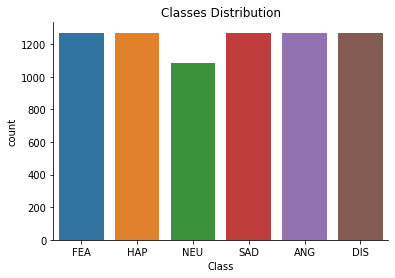

In [ ]:
plt.title("Classes Distribution")
sns.countplot(x = data_df["Class"])
sns.despine(top = True, right = True, left = False, bottom = False)

## **Constants**

In [ ]:
# FRAME_LENGTH = 1024         # default 2048
# HOP_LENGTH = 256            # default 512
SAMPLING_RATE = 22050       # default 22050
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.0001

## **Visulize the Time domain of the audio and play it**

In [ ]:
# shows the sound waves
def visualize(path: str, emotion):
   
    # reading the audio file
    raw = wave.open(path)
     
    # reads all the frames
    # -1 indicates all or max frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
     
    # gets the frame rate
    f_rate = raw.getframerate()
    # to Plot the x-axis in seconds you need get the frame rate and divide by size of your signal to create a Time Vector spaced linearly with the size of the audio file
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
    )
 
    # using matplotlib to plot
    # creates a new figure
    plt.figure(1)
     
    # title of the plot
    plt.title("Waveform of " + emotion)
     
    # label of x-axis
    plt.xlabel("Time")
    
    # actual plotting
    plt.plot(time, signal)
     
    # shows the plot
    # in new window
    plt.show()
 
    # you can also save the plot using
    # plt.savefig('filename')

## **Waveform plots and audio displays of each class**

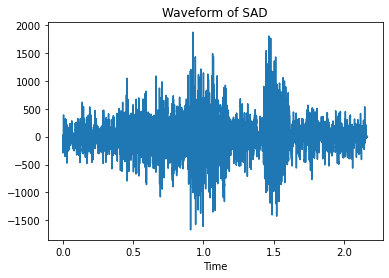

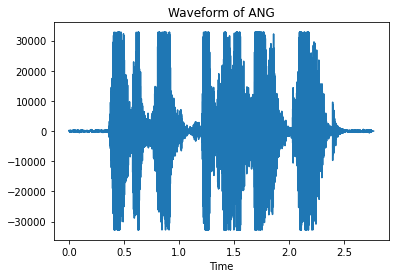

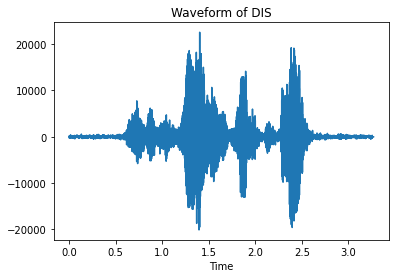

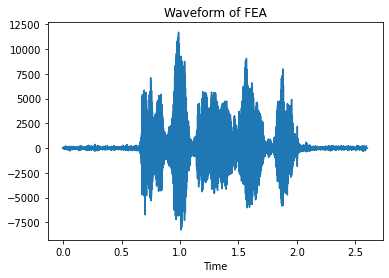

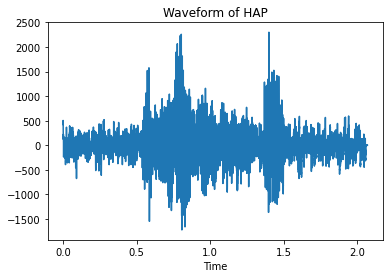

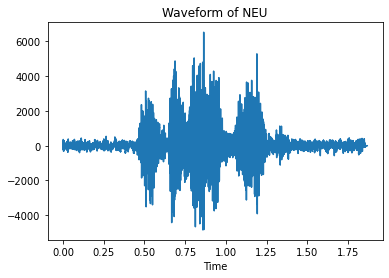

In [ ]:
emotions = ["SAD", "ANG","DIS","FEA","HAP","NEU"]
for emotion in emotions:
  path = np.array(data_df["File_path"][data_df["Class"] == emotion])[0]
  visualize(path, emotion)
  display(Audio(path)) 

## **First Feature Space: ZCR and Energy --> (we can add more features)**


In [ ]:
def custom_features(x):
  zcrs = sum(np.diff(np.sign(x)) != 0)
  absolute_x = abs(x)
  energy = np.mean(absolute_x*absolute_x)     # this takes less computation time
  return np.array([zcrs,energy])

## **Second Feature Space: Mel Spectorgram**

In [ ]:
def mel_spectrogram(x):
  S = librosa.feature.melspectrogram(y=x)
  return S

## **Map each emotion class to specific integer 0 -> 5**

In [ ]:
def extract_label(label_string):
  map = {
      "SAD":0,
      "ANG":1,
      "DIS":2,
      "FEA":3,
      "HAP":4,
      "NEU":5
  }
  return map[label_string]

In [ ]:
def audio_equalling(data_df):
  samples = []
  labels = []
  min_len = np.Inf               # minimum length =27959 when sr=22050
  equalled_samples = []

  # to get the length of smallest audio file
  for i in range(len(data_df)):
    samples.append(librosa.load(data_df['File_path'][i],sr=SAMPLING_RATE)[0])
    min_len = min(min_len,len(samples[i]))

  # add zero padding vector equal to difference between maximum audio and audio length
  # samples = np.array(samples)
  # for i in range(len(samples)):
  #   samples[i] = np.concatenate((samples[i],np.zeros(max_len - len(samples[i]))),axis=0)

  # divde the samples according to the smallest audio length and clip the incompleted samples assuming most of the audio files contain no information at the end of the audio
  # to do zero padding for the neglicting part
  for i in range(len(samples)):
    it = len(samples[i]) // min_len
    label = extract_label(data_df["Class"][i])
    for j in range(it):
      equalled_samples.append(samples[i][j*min_len+1:(j+1)*min_len])
      labels.append(label)

  return equalled_samples,np.array(labels)

In [ ]:
def create_feature_spaces(samples):
  d1 = []
  d2 = []

  # samples,labels = audio_equalling(data_df)
  for i in range(len(samples)):
      d1.append(np.concatenate((samples[i],custom_features(samples[i]))))
      # d2.append(mel_spectrogram(samples[i]))

  # TODO identify the datatype for the numpy
  return np.array(d1).astype(float),np.array(d2).astype(float)

In [ ]:
samples,labels = audio_equalling(data_df)         # takes around 8-10 mins

In [ ]:
# takes around 12min --> need to optimize it
d1,d2 = create_feature_spaces(samples)    # I have commented the mel-spectrogram feature space for now

In [ ]:
d1_reshaped = np.reshape(d1,(d1.shape[0],1,d1.shape[1]))

In [ ]:
print(d1_reshaped.shape)
print(labels.shape)

(10902, 1, 27960)
(10902,)


In [ ]:
# TODO dataset after pre-processing is unbalanced
train_features, test_features, train_labels, test_labels = train_test_split(d1_reshaped,labels, test_size=0.3, random_state=42,stratify=labels)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.05, random_state=42,stratify=train_labels)

In [ ]:
print(train_features.shape)
print(train_labels.shape)

(7249, 1, 27960)
(7249,)


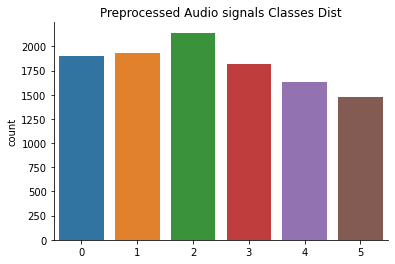

In [ ]:
plt.title("Preprocessed Audio signals Classes Dist")
sns.countplot(x = labels)
sns.despine(top = True, right = True, left = False, bottom = False)

In [ ]:
del samples
del labels

In [ ]:
del d1
del d1_reshaped

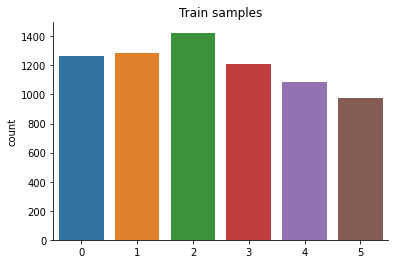

In [ ]:
plt.title("Train samples")
sns.countplot(x = train_labels)
sns.despine(top = True, right = True, left = False, bottom = False)

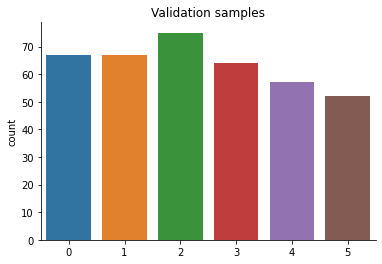

In [ ]:
plt.title("Validation samples")
sns.countplot(x = val_labels)
sns.despine(top = True, right = True, left = False, bottom = False)

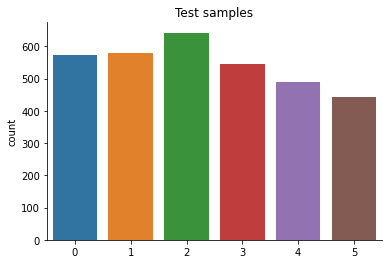

In [ ]:
plt.title("Test samples")
sns.countplot(x = test_labels)
sns.despine(top = True, right = True, left = False, bottom = False)

In [ ]:
print(len(train_features[0]))

1


## **Model Building using Keras for demo**

In [ ]:
from keras.models import Sequential
from keras.layers import MaxPool1D, Conv1D, Flatten,Dropout,Dense

#create model
model = Sequential()
#add model layers
model.add(Conv1D(512, kernel_size=5, activation='relu', input_shape=(len(train_features[0]),1)))
model.add(MaxPool1D(5))
model.add(Conv1D(512, kernel_size=5, activation='relu'))
model.add(MaxPool1D(5))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPool1D(5))
# feature extraction is done (CNN layer)

# dense layer for classification
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(6,activation='softmax'))



ValueError: ignored

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
print(model.summary())

# for first layer 3072 ----> 512(# of filter) * (kernel * channels + 1)
# Pooling layers have no parameters


## **Train Keras Model**

In [ ]:
train_labels = np.array(train_labels)

In [ ]:
results = model.fit(train_features,train_labels,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1)

## **Model Building using Pytorch**

In [ ]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)

        self.conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5,stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2)

        self.conv3 = nn.Conv1d(in_channels=512, out_channels=128, kernel_size=5,stride=1)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2)
        
        # self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(in_features=446464,out_features=256)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=6)


    # Defining the forward pass    
    def forward(self, x):
        # print(x.shape)
        x = self.pool1(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = self.pool3(F.relu(self.conv3(x)))
        # print(x.shape)
        x = torch.flatten(x,1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # print(x.shape)
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=-1)
        # print(x.shape)
        return x

# create networks
# net = Net().to(device)
net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    return torch.tensor(self.feat_arr[index]).float(),torch.tensor((self.label[index]))
    #TODO
  def __len__(self):
    return len(self.feat_arr)

In [ ]:
train_dataset = dataset(train_features,train_labels)

# TODO what is num_worker do
train_dataloader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
val_dataset = dataset(val_features,val_labels)

# TODO what is num_worker do
val_dataloader = DataLoader(val_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

## **TRials Pytorch**

In [ ]:
def run_model(model,dataloader,optimizer):

  model.train()       #https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

  pred = []
  criterion = nn.CrossEntropyLoss()
  total_loss = 0
  for (data,labels) in dataloader:
    # data = data.to(device)
    # labels = labels.to(device)
    print(data.shape)
    print(labels.shape)
    optimizer.zero_grad()
    # output = model(data)
    output = model.forward(data)
    
    # Labels --> must be [128,...]

    loss = criterion(output,labels)
    # output_traspose = tf.transpose(output)
    # loss_ = loss(output_traspose,label)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
    pred += labels.tolist()

    return labels,pred,total_loss/len(dataloader)

In [ ]:
import torch.optim as optim



optimizer = optim.Adam(net.parameters(), lr=0.001)
# lr_scheduler provides several methods to adjust the learning rate based on the number of epochs. torch.optim.lr_scheduler.
# to be discussed later
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for e in range(2):
  labels,pred,loss = run_model(net,train_dataloader,optimizer)
  print(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.0009905432576444093
torch.Size([4, 1, 27960])
torch.Size([4])
0.0011271879413939285


In [ ]:
criterion = nn.CrossEntropyLoss()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Cell

In [ ]:
dataiter = iter(train_dataloader)
data, l = dataiter.next()



conv1 = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=5,stride=1)
pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5,stride=1)
pool2 = nn.MaxPool1d(kernel_size=5, stride=2)
conv3 = nn.Conv1d(in_channels=512, out_channels=128, kernel_size=5,stride=1)
pool3 = nn.MaxPool1d(kernel_size=5, stride=2)

fc1 = nn.Linear(1741,256)      #
fc2 = nn.Linear(in_features=256,out_features=6)

print("Original Size: ",data.shape)
x = conv1(data)

# (input - kernel_size + 2*padding)/stride  +1 --------> (27960 - 5 + 2*0)/1  + 1 = 27956
print("First Conv layer",x.shape)

x = pool1(x)

# (input - kernel_size )/stride
print("First pool layer",x.shape)

x = conv2(x)
print("Second Conv layer",x.shape)

x = pool2(x)
print("Second pool layer",x.shape)

x = conv3(x)
print("third Conv layer",x.shape)

x = pool3(x)
print("third pool layer",x.shape)


x = fc1(x)
print("first FC layer",x.shape)

x = fc2(x)
print("Second FC layer",x.shape)

# net.forward(data)

x = F.softmax(x,dim=1)
print(x.shape)
loss = criterion(x,l)

In [ ]:
criterion = nn.CrossEntropyLoss()
loss = criterion(x,labels[0])

In [ ]:
print(labels.shape)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
# xx = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(xx, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(root="data",train=True,download=True,transform=ToTensor())


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=4)

In [ ]:
dataiter = iter(train_dataloader)
data, labels = dataiter.next()

data.shape

## **Final1**

In [ ]:
from tqdm import tqdm
from collections import defaultdict
def train_model(model, train_dataloader, val_dataloader):
    
    
    # to store the results
    summary = defaultdict(list)
    # to select GPU for running
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # identifying the loss and optimizer funtions for weights calculations
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  

    # to apply the gpu for the model and loss functions
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for inputs, labels in tqdm(train_dataloader):

                optimizer.zero_grad()
                train_labels = labels.to(device)
                train_inputs = inputs.to(device)

                output = model(train_inputs)
                
                batch_loss = criterion(output, train_labels)
                total_loss_train += float(batch_loss.item())
                
                acc = (output.argmax(dim=1) == train_labels).sum().item()
                total_acc_train += float(acc)
                del acc


                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            # scheduler.step()
            total_acc_val = 0
            total_loss_val = 0

            # Disabling gradient calculation is useful for inference to avoid dependency
            with torch.no_grad():

                # repreat for the previous but for the validation set 
                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += float(batch_loss.item())
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += float(acc)
                    del acc
                
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_features): .3f} | Train Accuracy: {total_acc_train / len(train_features): .3f} | Val Loss: {total_loss_val / len(val_features): .3f} | Val Accuracy: {total_acc_val / len(val_features): .3f}')
            

            summary['train_acc'].append(total_acc_train/len(train_features))
            summary['train_loss'].append(total_loss_train/len(train_features))
            summary['val_acc'].append(total_acc_val/len(val_features))
            summary['val_loss'].append(total_loss_val/len(val_features))

    return model,summary

In [ ]:
model, summary = train_model(net, train_dataloader, val_dataloader)

100%|██████████| 907/907 [05:29<00:00,  2.75it/s]


Epochs: 1 | Train Loss:  0.203 | Train Accuracy:  0.309 | Val Loss:  0.190 | Val Accuracy:  0.343


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 2 | Train Loss:  0.192 | Train Accuracy:  0.356 | Val Loss:  0.184 | Val Accuracy:  0.382


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 3 | Train Loss:  0.187 | Train Accuracy:  0.376 | Val Loss:  0.186 | Val Accuracy:  0.369


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 4 | Train Loss:  0.182 | Train Accuracy:  0.394 | Val Loss:  0.185 | Val Accuracy:  0.395


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 5 | Train Loss:  0.174 | Train Accuracy:  0.428 | Val Loss:  0.185 | Val Accuracy:  0.369


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 6 | Train Loss:  0.158 | Train Accuracy:  0.490 | Val Loss:  0.196 | Val Accuracy:  0.385


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 7 | Train Loss:  0.136 | Train Accuracy:  0.568 | Val Loss:  0.229 | Val Accuracy:  0.380


100%|██████████| 907/907 [05:29<00:00,  2.75it/s]


Epochs: 8 | Train Loss:  0.116 | Train Accuracy:  0.639 | Val Loss:  0.252 | Val Accuracy:  0.377


100%|██████████| 907/907 [05:29<00:00,  2.75it/s]


Epochs: 9 | Train Loss:  0.094 | Train Accuracy:  0.713 | Val Loss:  0.336 | Val Accuracy:  0.372


100%|██████████| 907/907 [05:29<00:00,  2.75it/s]


Epochs: 10 | Train Loss:  0.078 | Train Accuracy:  0.766 | Val Loss:  0.348 | Val Accuracy:  0.346


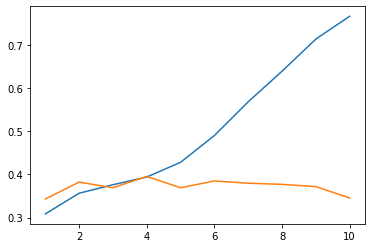

In [ ]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, endpoint=True)
plt.plot(x_axis, summary['train_acc'])
plt.plot(x_axis, summary['val_acc'])

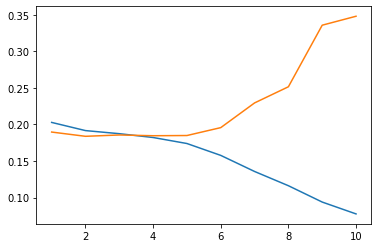

In [ ]:
plt.plot(x_axis, summary['train_loss'])
plt.plot(x_axis, summary['val_loss'])

In [ ]:
EPOCHS = 5
model, summary = train_model(net, train_dataloader, val_dataloader)

100%|██████████| 907/907 [05:30<00:00,  2.74it/s]


Epochs: 1 | Train Loss:  0.204 | Train Accuracy:  0.301 | Val Loss:  0.190 | Val Accuracy:  0.351


100%|██████████| 907/907 [05:29<00:00,  2.76it/s]


Epochs: 2 | Train Loss:  0.192 | Train Accuracy:  0.355 | Val Loss:  0.185 | Val Accuracy:  0.374


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 3 | Train Loss:  0.187 | Train Accuracy:  0.371 | Val Loss:  0.180 | Val Accuracy:  0.416


100%|██████████| 907/907 [05:28<00:00,  2.76it/s]


Epochs: 4 | Train Loss:  0.182 | Train Accuracy:  0.404 | Val Loss:  0.179 | Val Accuracy:  0.401


100%|██████████| 907/907 [05:29<00:00,  2.76it/s]


Epochs: 5 | Train Loss:  0.172 | Train Accuracy:  0.441 | Val Loss:  0.186 | Val Accuracy:  0.387


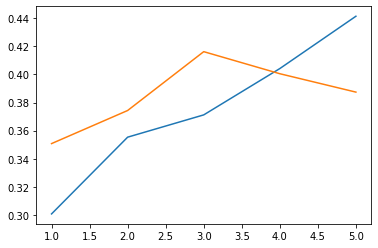

In [ ]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, endpoint=True)
plt.plot(x_axis, summary['train_acc'])
plt.plot(x_axis, summary['val_acc'])

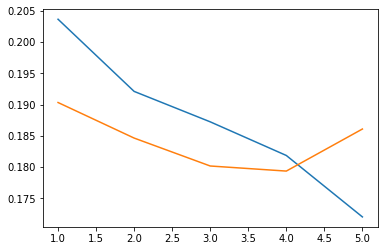

In [ ]:
plt.plot(x_axis, summary['train_loss'])
plt.plot(x_axis, summary['val_loss'])

In [ ]:
def test_model(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    y_pred=[]
    y_true=[]

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    model.eval()
    # Disabling gradient calculation is useful for inference to avoid dependency
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              test_input = test_input.to(device)
              output = model(test_input)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              
              y_pred.extend((torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()) # Save Prediction
      
              test_label = test_label.data.cpu().numpy()
              y_true.extend(test_label) # Save Truth

            
    print(f'Test Accuracy: {total_acc_test / len(test_features): .3f}')
    return y_pred, y_true, total_acc_test / len(test_features)

In [ ]:
test_dataloader = DataLoader(dataset(test_features,test_labels),batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
y_pred,y_true,total_acc = test_model(net,test_dataloader)

Test Accuracy:  0.367


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_true, y_pred, average=None)

array([0.48834628, 0.59621993, 0.1962963 , 0.11314985, 0.25798212,
       0.3210576 ])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[440,   6,  42,   6,   6,  72],
       [ 16, 347,  77,  12,  62,  65],
       [313,  57, 106,  15,  40, 111],
       [229,  81,  68,  37,  58,  73],
       [ 69,  89,  81,  24, 101, 126],
       [163,   5,  64,  14,  26, 170]])

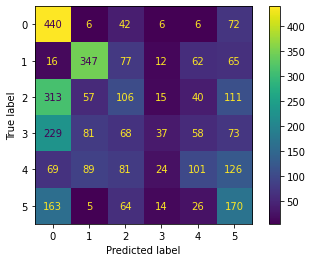

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()